# Spectra to calculate k-alfa and k-beta

In [1]:
scan_file = '/homelocal/rhoms/tmp/clear_data/20180420.dat'
calibration_file = '/homelocal/rhoms/develop/tmp/mpp/mpp_calib_json_000.txt'
scan_id = 244122

In [2]:
import sys
import logging
import numpy as np
sys.path.append('/homelocal/rhoms/develop/pycharm/MythenPostProcessing/')
from bl22mythenlib.calibration import Calibration
from bl22mythenlib.specreader import read_scan
from bl22mythenlib.mathfunc import get_mythen_data
from bl22mythenlib.constants import ENERGY, BAD_PIXEL, CEOUT

logging.basicConfig(level=logging.INFO)
calib = Calibration()
calib.load_from_file(calibration_file)

INFO:bl22mythenlib.Calibration:Loading calibration from: /homelocal/rhoms/develop/tmp/mpp/mpp_calib_json_000.txt


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot(data):
    if len(data.shape) == 1:
        plt.plot(data)
    else:
        for i in data:
            plt.plot(i)


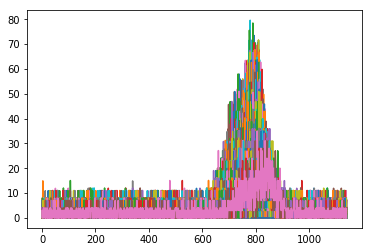

In [4]:
scan_data, scan_snapshot = read_scan(scan_file, scan_id)
m_data = get_mythen_data(scan_data)
plot(m_data)

In [5]:
# The original code use only the noise form 0 to a pixel_limit_noise 600. 
# Refactor to use the data out of the roi
low_noise = m_data[:,0:calib.roi_low].mean()
high_noise = m_data[:,calib.roi_high:BAD_PIXEL].mean()
noise = (low_noise + high_noise) / 2
print(noise)
m_wn = m_data - noise

2.026349917447595


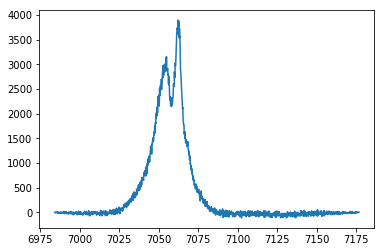

In [6]:
energies = np.array(scan_data[CEOUT])
p0_e = calib.energy2pixel(energies).astype(int)
p0_delta = p0_e - calib.p0
min_scale = 0 + p0_delta.min()
max_scale = BAD_PIXEL + p0_delta.max()
pixel_scale = np.array(range(min_scale, max_scale))
scan_sum = np.zeros(pixel_scale.shape[0])
for p0_d, i in zip(p0_delta, m_wn):
    min_pixel = 0 + p0_d + np.abs(min_scale)
    max_pixel = min_pixel + BAD_PIXEL
    scan_sum[min_pixel:max_pixel] = scan_sum[min_pixel:max_pixel] + i

energy_scale = calib.pixel2energy(pixel_scale)
plt.plot(energy_scale, scan_sum)

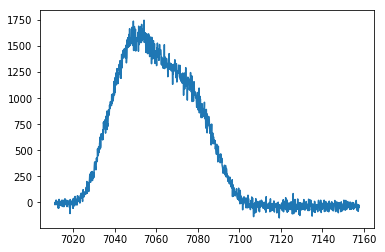

In [9]:
min_scale = 0 
max_scale = BAD_PIXEL 
energies = np.array(scan_data[CEOUT])
p0_e = calib.energy2pixel(energies).astype(int)
p0_delta = p0_e - calib.p0
pixel_scale = np.array(range(min_scale, max_scale))
resolution = np.zeros(pixel_scale.shape[0])
for p0_d, i in zip(p0_delta, m_wn):
    if p0_d > 0:
        min_pixel = p0_d
        max_pixel = BAD_PIXEL - p0_d
        resolution[0:max_pixel] = resolution[0:max_pixel] + i[min_pixel:BAD_PIXEL]
    else:
        min_pixel = -p0_d
        max_pixel = BAD_PIXEL + p0_d
        resolution[min_pixel: BAD_PIXEL] = resolution[min_pixel: BAD_PIXEL] \
            + i[0: max_pixel]

energy_scale = calib.pixel2energy(pixel_scale)
plt.plot(energy_scale, resolution)